# Metropolis-Hastings (MH)

MH is a Monte Carlo Markov Chain algorithm for sampling from the posterior distribution in Bayesian analysis. Monte carlo methods simply involve repeatedly sampling some event that includes randomness to create a stochastic simulation to a problem that could potential be deterministic. Markov chains are sequential random variables where the distribution of the current variable $X^{t}$ is only dependent on the previous variable $X^{t-1}$.

The general idea behind MH is to use a proxy distribution to generate samples that are accepted as a sample from the true posterior distribution given a high enough likelihood. MH utilizes a random-walk approach plus an acceptance/rejection rule to move closer to the true posterior distribution with each interation.

#### Here are the steps:

1. Select a starting point $\theta^{0}$ where $P(\theta^{0}|y)>0$.
2. For $t$ in $1, 2, ..., n$,<br>
    a. Sample a proposal point ($\theta^{*}$), for testing, from the jumping (i.e. proxy) distribution at time $t$ ($J_{t}(\theta^{*}|\theta^{t-1})$). <br>
    b. Calculate the ratio of densities using the posterior distribution. The ratio is $r=\frac{p(\theta^{*}|y)/J_{t}(\theta^{*}|\theta^{t-1})}{p(\theta^{t-1}|y)/J_{t}(\theta^{t-1}|\theta^{*})}$. In the 2 examples below, $J_{t}$ is the normal distribution, which is symmetric, so the two $J_{t}$ distributions cancel each other out.<br>
    c. If $unif(0, 1) < min(1, r)$, then $\theta^{t} = \theta^{*}$. That is, the proposal point is accepted. Otherwise, $\theta^{t} = \theta^{t-1}$.

#### Posterior Definition:
$p(\mu|x) \propto p(x|\mu) * p(\mu)$<br>
**posterior** proportional to **likelihood** times **prior**

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import (
    norm, multivariate_normal as mnorm, uniform as unif
)
import seaborn as sns
import time

In [2]:
plt.rcParams["figure.figsize"] = (20,10)

sns.set(font_scale=2)
sns.set_style('whitegrid')

### Univariate Case

In [3]:
def mh1(initial, pstd, nsim, nburn=None):
    """
    Parameters
    ----------
    initial : numeric
        starting point
    pstd : numeric
        standard deviation of the jumping distribution
    nsim : integer
        number of iterations to run
    nburn : integer
        number of iterations to remove at the beginning 
        of sequence to guarantee a converged sequence

    Returns
    -------
    tuple (samples, accepted / nsim, actual)
        samples : the final sequence of samples
        accepted / nsim : the acceptance rate, the number of proposal points accepted
        actual : the values obtained by sampling directly from 
            the posterior distribution using conjugacy
    """
    samples = []
    samples.append(initial)
    
    mu = 2.1
    sig = 1.7
    
    # prior
    pmu = 0 
    psig = 0.8
    
    # data for likelihood
    nd = 100
    d = norm.rvs(loc=mu, scale=sig, size=nd, random_state=112)
    
    # actual posterior using conjugate
    actual = norm.rvs(
        loc=(
            ((1/(psig ** 2) + nd/(sig ** 2)) ** -1) * 
            (pmu/(psig ** 2) + sum(d)/(sig ** 2))
        ), 
        scale=np.sqrt((1/(psig ** 2) + nd/(sig ** 2)) ** -1), 
        size=10000
    )
    
    accepted = 0
    
    for i in range(1, nsim):
        star = norm.rvs(loc=samples[i - 1], scale=pstd, size=1)
        
        def pfunc(x, d, mu, sig, pmu, psig):
            like_ = np.prod([norm.pdf(i, loc=x, scale=sig) for i in d])
            prior_ = norm.pdf(x, loc=pmu, scale=psig)
            return like_ * prior_
        
        r = (
            pfunc(star, d, mu, sig, pmu, psig) / 
            pfunc(samples[i - 1], d, mu, sig, pmu, psig)
        )
        
        if unif.rvs(loc=0, scale=1, size=1) < min(1, r):
            samples.append(star[0])
            accepted += 1
            
        else:
            samples.append(samples[i - 1])
            
    if isinstance(nburn, int):
        samples = samples[-(nsim - nburn):]
    
    return (samples, accepted / nsim, actual)

In [4]:
stime = time.time()

s1, r1, a1 = mh1(initial=0, pstd=0.4, nsim=6000, nburn=1000)
s2, r2, a2 = mh1(initial=0, pstd=0.4, nsim=6000, nburn=1000)

etime = time.time()

print("Sampling time (in secs): " + str(round(etime - stime, 4)))

Sampling time (in secs): 252.6815


In [5]:
for idx, rate in enumerate([r1, r2]):
    print(
        "Acceptance rate for chain {}: {}%"
        .format(idx + 1, round(100 * rate, 1))
    )

Acceptance rate for chain 1: 43.7%
Acceptance rate for chain 2: 43.6%


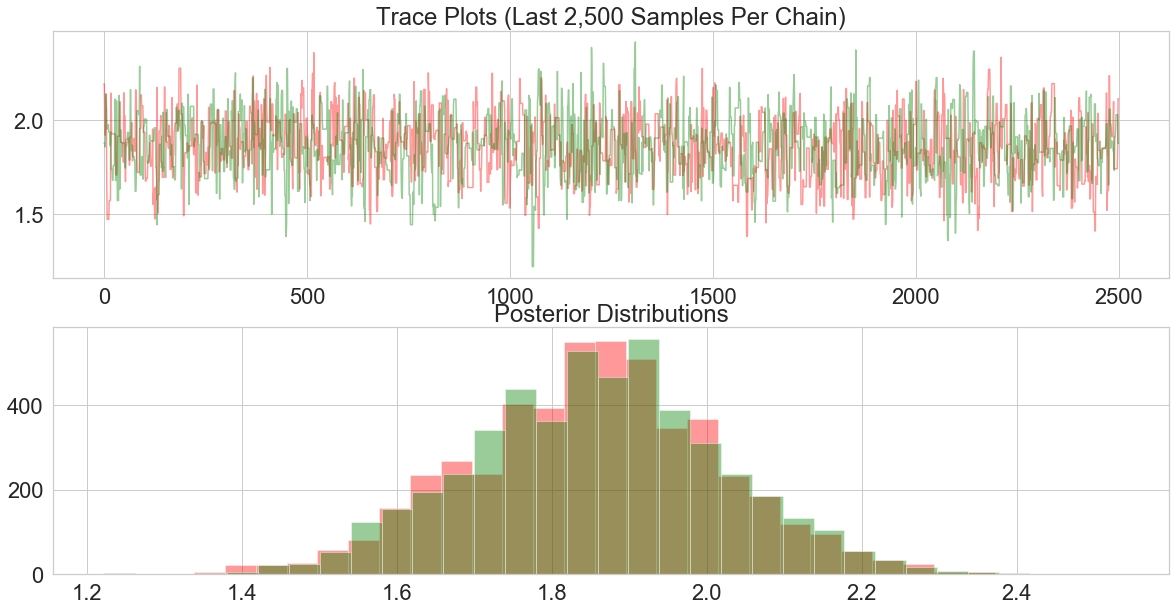

In [6]:
fig, axes = plt.subplots(2, 1)

axes[0].title.set_text('Trace Plots (Last 2,500 Samples Per Chain)')
axes[0].plot(s1[-2500:], c='red', alpha=0.4)
axes[0].plot(s2[-2500:], c='green', alpha=0.4)

axes[1].title.set_text('Posterior Distributions')
axes[1].hist(s1, bins=30, color='red', alpha=0.4)
axes[1].hist(s2, bins=30, color='green', alpha=0.4)

plt.show()

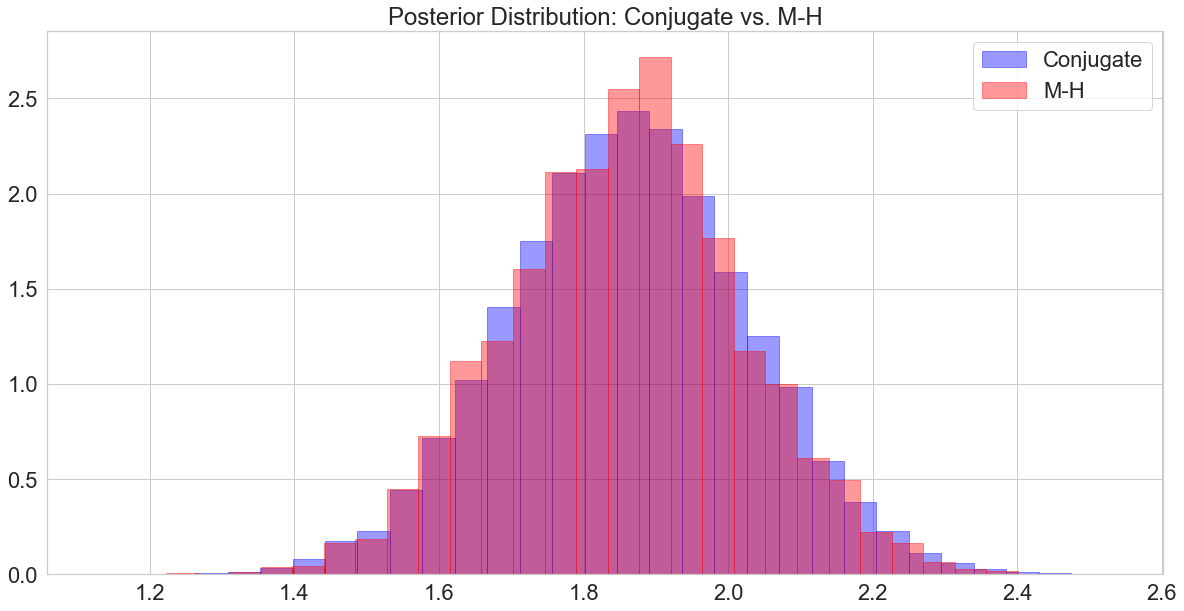

In [7]:
plt.hist(np.concatenate((a1, a2)), label='Conjugate', 
         density=True, bins=30, color='blue', edgecolor='blue', alpha=0.4)
plt.hist(np.concatenate((s1, s2)), label='M-H', 
         density=True, bins=30, color='red', edgecolor='red', alpha=0.4)
plt.title('Posterior Distribution: Conjugate vs. M-H')
plt.legend()
plt.show()

### Multivariate Case

In [8]:
def mh2(initial, pstd, nsim, nburn=None):
    """
    Parameters
    ----------
    initial : list of numeric [0, 0]
        starting point
    pstd : list of lists of numeric [[1, 0], [0, 1]]
        standard deviation of the jumping distribution
    nsim : integer
        number of iterations to run
    nburn : integer
        number of iterations to remove at the beginning 
        of sequence to guarantee a converged sequence

    Returns
    -------
    tuple (samples, accepted / nsim, actual)
        samples : the final sequence of samples
        accepted / nsim : the acceptance rate, the number of proposal points accepted
        actual : the values obtained by sampling directly from 
            the posterior distribution using conjugacy
    """
    samples = np.array([initial])
    
    mu = [1, 2]
    sig = [[1, 0.9], [0.9, 1]]
    
    # actual posterior
    actual = mnorm.rvs(mean=mu, cov=sig, size=10000)
    
    accepted = 0
    
    for i in range(1, nsim):
        star = mnorm.rvs(mean=samples[i - 1], cov=pstd, size=1)
        
        r = (
            mnorm.pdf(star, mean=mu, cov=sig) / 
            mnorm.pdf(samples[i - 1], mean=mu, cov=sig)
        )
        
        if unif.rvs(loc=0, scale=1, size=1) < min(1, r):
            star = np.array([star.tolist()])
            samples = np.concatenate((samples, star), axis=0)
            accepted += 1
            
        else:
            samples = np.concatenate(
                (samples, np.array([samples[i - 1].tolist()])), 
                axis=0
            )
            
    if isinstance(nburn, int):
        samples = samples[-(nsim - nburn):]
    
    return (samples, accepted / nsim, actual)

In [9]:
stime = time.time()

s3, r3, a3 = mh2( 
    initial=[0, 0], pstd=[[0.7, 0], [0, 1]], nsim=12000, nburn=2000
)
s4, r4, a4 = mh2(
    initial=[0, 0], pstd=[[0.7, 0], [0, 1]], nsim=12000, nburn=2000
)

etime = time.time()

act3_0 = a3[:, 0]
act3_1 = a3[:, 1]

act4_0 = a4[:, 0]
act4_1 = a4[:, 1]

sim3_0 = s3[:, 0]
sim3_1 = s3[:, 1]

sim4_0 = s4[:, 0]
sim4_1 = s4[:, 1]

print("Sampling time (in secs): " + str(round(etime - stime, 4)))

Sampling time (in secs): 16.2006


In [10]:
for idx, rate in enumerate([r3, r4]):
    print(
        "Acceptance rate for chain {}: {}%"
        .format(idx + 1, round(100 * rate, 1))
    )

Acceptance rate for chain 1: 34.5%
Acceptance rate for chain 2: 34.3%


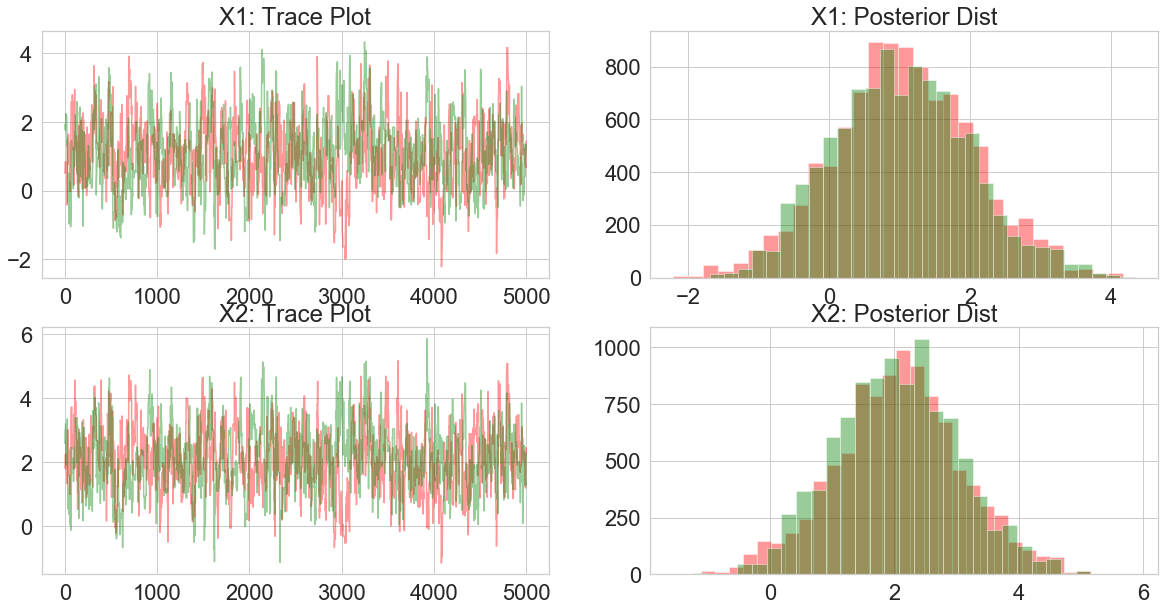

In [11]:
fig, axes = plt.subplots(2, 2)

axes[0, 0].title.set_text('X1: Trace Plot')
axes[0, 0].plot(sim3_0[-5000:], c='red', alpha=0.4)
axes[0, 0].plot(sim4_0[-5000:], c='green', alpha=0.4)

axes[0, 1].title.set_text('X1: Posterior Dist')
axes[0, 1].hist(sim3_0, bins=30, color='red', alpha=0.4)
axes[0, 1].hist(sim4_0, bins=30, color='green', alpha=0.4)

axes[1, 0].title.set_text('X2: Trace Plot')
axes[1, 0].plot(sim3_1[-5000:], c='red', alpha=0.4)
axes[1, 0].plot(sim4_1[-5000:], c='green', alpha=0.4)

axes[1, 1].title.set_text('X2: Posterior Dist')
axes[1, 1].hist(sim3_1, bins=30, color='red', alpha=0.4)
axes[1, 1].hist(sim4_1, bins=30, color='green', alpha=0.4)

plt.show()

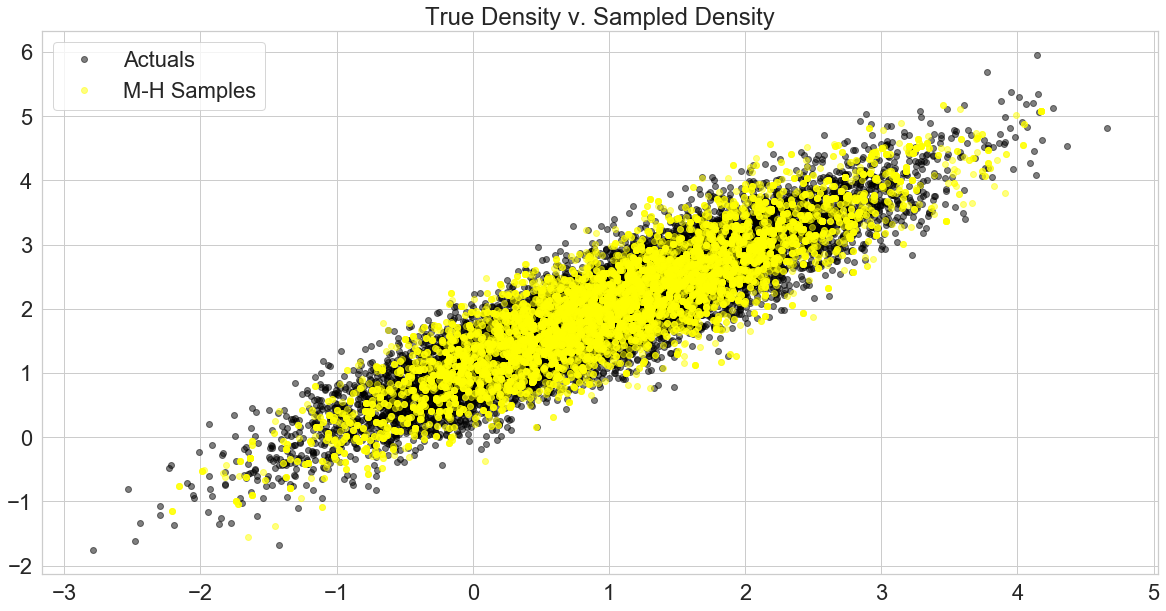

In [12]:
plt.plot(act3_0, act3_1, 'o', c='black', alpha=0.5, label='Actuals')
plt.plot(sim3_0, sim3_1, 'o', c='yellow', alpha=0.5, label='M-H Samples')
plt.title('True Density v. Sampled Density')
plt.legend()
plt.show()